# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [321]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

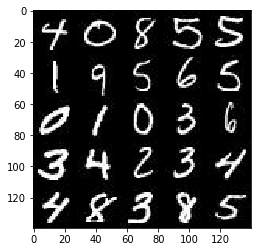

In [322]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

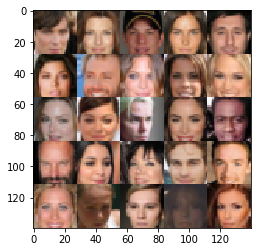

In [323]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [324]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [325]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [326]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # Introdce noise to improve generalization
    dropout_keep_prob = 0.1
        
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xn
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same',
                             kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, dropout_keep_prob, training=True)
        # 14x14x32
                
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same',
                             kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, dropout_keep_prob, training=True)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same',
                             kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, dropout_keep_prob, training=True)
        # 7x7x256
                
        x4 = tf.layers.conv2d(relu3, 512, 3, strides=2, padding='same',
                             kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        relu4 = tf.layers.dropout(relu4, dropout_keep_prob, training=True)
        # 7x7x512
            
        # Flatten it
        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [327]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2 
    # Introdce noise to improve generalization
    dropout_keep_prob = 0.1
        
    with tf.variable_scope('generator', reuse=not(is_train)):
        # Input layer is 100
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        x1 = tf.layers.dropout(x1, dropout_keep_prob, training=True)
        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        # 4x4x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.relu(x3)
        # 7x7x128
                
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.nn.relu(x4)
        # 14x14x64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits) 
        # 28x28xn
        
        return out    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [328]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [329]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize - http://ruishu.io/2016/12/27/batchnorm/
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    # Multiply learning rate by two to prevent the discriminator's loss to go to zero 
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate*2.0, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_updates):
        # Ensures that we execute the update_ops before performing the train_step
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [330]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [331]:
class GAN:
    def __init__(self, data_shape, z_dim, learning_rate, data_image_mode, beta1=0.5):
        """
        Build GAN model
        :param z_dim: Z dimension
        :param learning_rate: Learning Rate
        :param beta1: The exponential decay rate for the 1st moment in the optimizer
        :param get_batches: Function to get batches
        :param data_shape: Shape of the data
        :param data_image_mode: The image mode to use for images ("RGB" or "L")
        """
        self.input_real, self.input_z, self.learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, data_shape[3])
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)    

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data (samples, height, width, number of channels)
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    net = GAN(data_shape, z_dim, learning_rate, data_image_mode, beta1=beta1)
    
    saver = tf.train.Saver()
    
    losses = []
    samples = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_number, batch_images in enumerate(get_batches(batch_size)):                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers - scale images to -1 - 1
                _ = sess.run(net.d_opt, feed_dict={net.input_real: (batch_images*2.0), net.input_z: batch_z})
                
                # Run the generator twice to prevent the discriminator's 
                ## to go to zero 
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z})
#                 _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z})

                if batch_number % 100 == 0:
                    show_generator_output(sess=sess,
                                          image_mode=data_image_mode,
                                          input_z=net.input_z,
                                          n_images=10,
                                          out_channel_dim=data_shape[3])
                
                    # At the end of each epoch, get the losses and print them out - scale images to -1 - 1
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: (batch_images*2.0)})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d),
                            "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                losses.append((train_loss_d, train_loss_g))

                    
    # Plot training losses                    
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

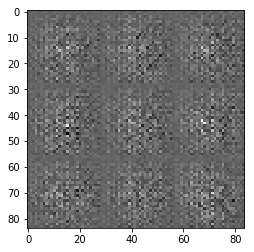

Epoch 1/20... Discriminator Loss: 1.3460... Generator Loss: 0.5161


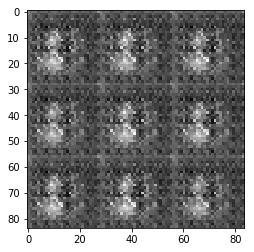

Epoch 1/20... Discriminator Loss: 0.3725... Generator Loss: 3.6748


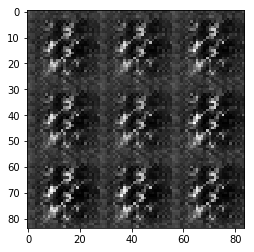

Epoch 1/20... Discriminator Loss: 0.1726... Generator Loss: 5.2201


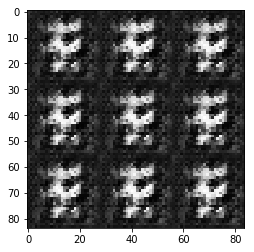

Epoch 1/20... Discriminator Loss: 0.2280... Generator Loss: 2.4514


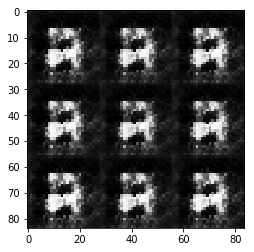

Epoch 1/20... Discriminator Loss: 0.0912... Generator Loss: 4.9281


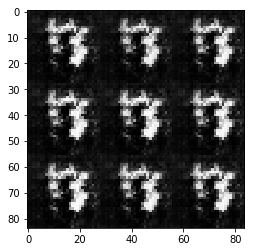

Epoch 2/20... Discriminator Loss: 0.1934... Generator Loss: 3.0931


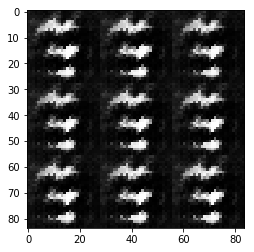

Epoch 2/20... Discriminator Loss: 0.2353... Generator Loss: 2.0749


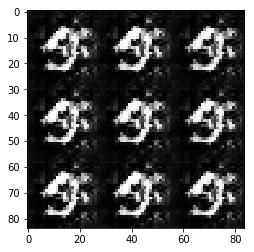

Epoch 2/20... Discriminator Loss: 0.0922... Generator Loss: 3.0786


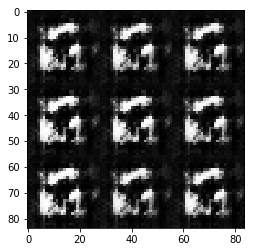

Epoch 2/20... Discriminator Loss: 0.0732... Generator Loss: 5.0116


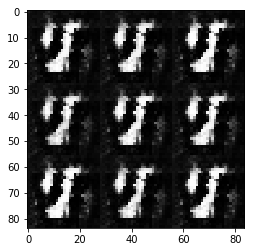

Epoch 2/20... Discriminator Loss: 0.0283... Generator Loss: 5.0034


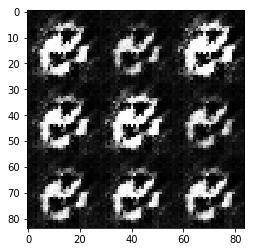

Epoch 3/20... Discriminator Loss: 0.0307... Generator Loss: 4.8403


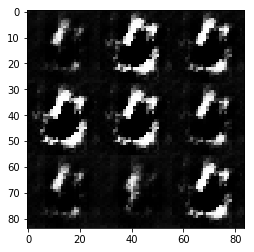

Epoch 3/20... Discriminator Loss: 0.0767... Generator Loss: 4.9993


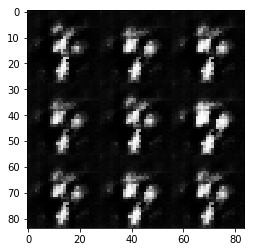

Epoch 3/20... Discriminator Loss: 0.4002... Generator Loss: 1.6529


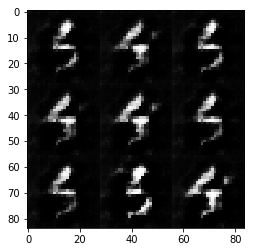

Epoch 3/20... Discriminator Loss: 0.1773... Generator Loss: 3.1512


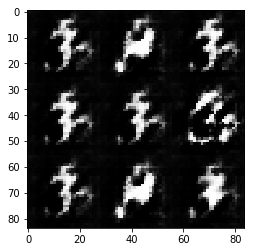

Epoch 3/20... Discriminator Loss: 0.3367... Generator Loss: 2.1734


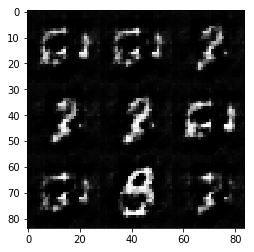

Epoch 4/20... Discriminator Loss: 0.0803... Generator Loss: 4.7048


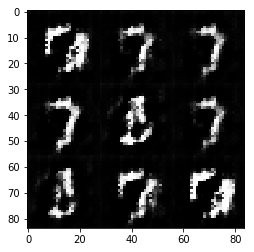

Epoch 4/20... Discriminator Loss: 0.1047... Generator Loss: 4.1166


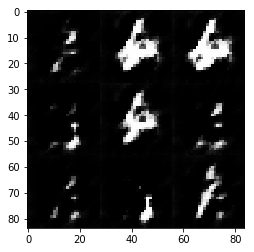

Epoch 4/20... Discriminator Loss: 0.1045... Generator Loss: 3.7690


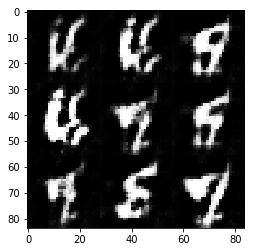

Epoch 4/20... Discriminator Loss: 0.1440... Generator Loss: 3.9120


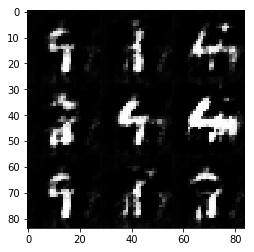

Epoch 4/20... Discriminator Loss: 0.9451... Generator Loss: 6.8677


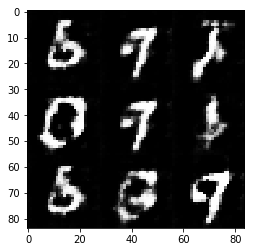

Epoch 5/20... Discriminator Loss: 0.6913... Generator Loss: 1.5606


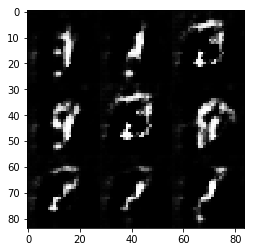

Epoch 5/20... Discriminator Loss: 0.9274... Generator Loss: 0.8557


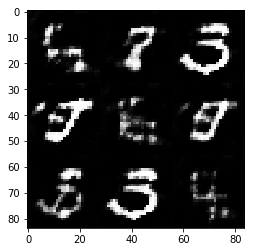

Epoch 5/20... Discriminator Loss: 2.1179... Generator Loss: 8.4271


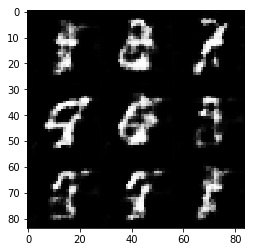

Epoch 5/20... Discriminator Loss: 0.1548... Generator Loss: 3.3975


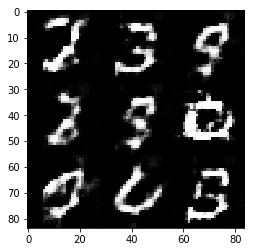

Epoch 5/20... Discriminator Loss: 0.9963... Generator Loss: 2.9797


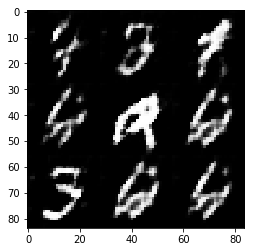

Epoch 6/20... Discriminator Loss: 0.3625... Generator Loss: 2.5893


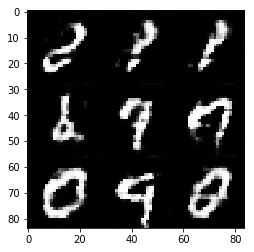

Epoch 6/20... Discriminator Loss: 0.4495... Generator Loss: 1.5798


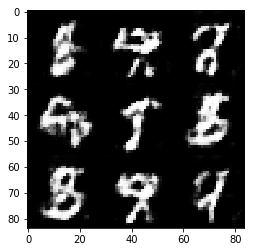

Epoch 6/20... Discriminator Loss: 0.2974... Generator Loss: 2.2524


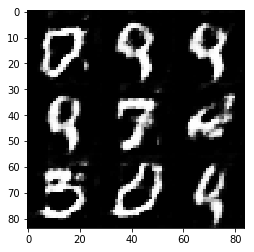

Epoch 6/20... Discriminator Loss: 1.6940... Generator Loss: 7.2601


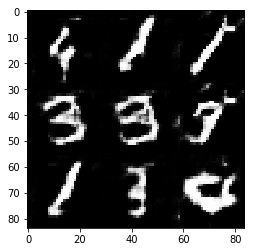

Epoch 6/20... Discriminator Loss: 2.1891... Generator Loss: 0.2429


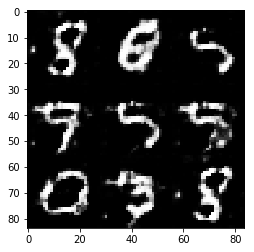

Epoch 7/20... Discriminator Loss: 0.1645... Generator Loss: 2.6389


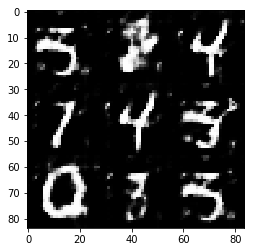

Epoch 7/20... Discriminator Loss: 0.4290... Generator Loss: 2.5242


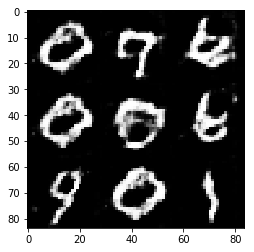

Epoch 7/20... Discriminator Loss: 0.5143... Generator Loss: 1.9450


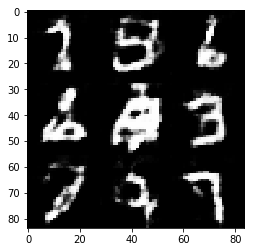

Epoch 7/20... Discriminator Loss: 1.1494... Generator Loss: 0.8933


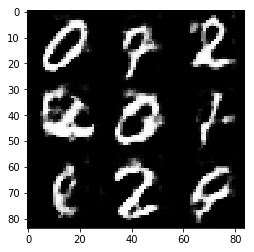

Epoch 7/20... Discriminator Loss: 0.9501... Generator Loss: 0.9478


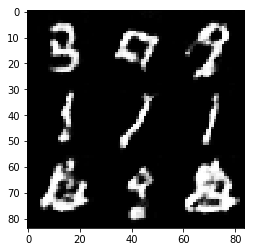

Epoch 8/20... Discriminator Loss: 0.2501... Generator Loss: 2.7328


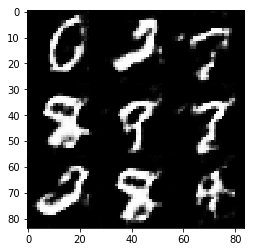

Epoch 8/20... Discriminator Loss: 0.4276... Generator Loss: 7.3811


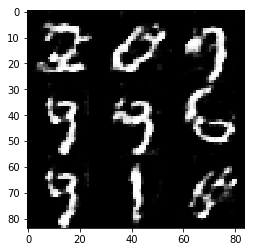

Epoch 8/20... Discriminator Loss: 0.6324... Generator Loss: 6.5982


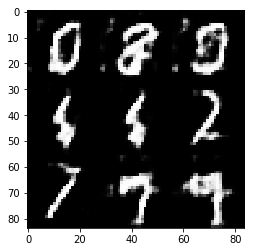

Epoch 8/20... Discriminator Loss: 1.3415... Generator Loss: 0.5713


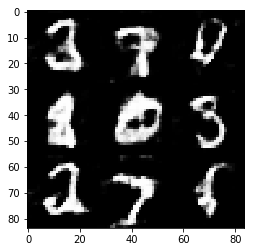

Epoch 8/20... Discriminator Loss: 0.9747... Generator Loss: 0.6313


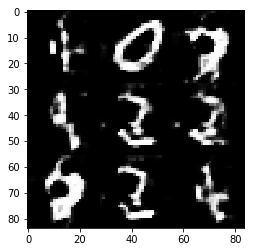

Epoch 9/20... Discriminator Loss: 0.1954... Generator Loss: 2.6129


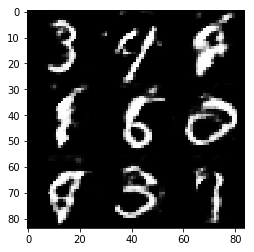

Epoch 9/20... Discriminator Loss: 0.1792... Generator Loss: 4.2075


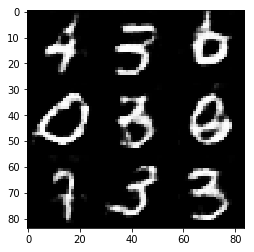

Epoch 9/20... Discriminator Loss: 0.4523... Generator Loss: 1.5272


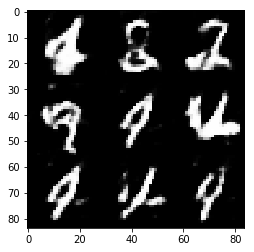

Epoch 9/20... Discriminator Loss: 0.2719... Generator Loss: 2.6275


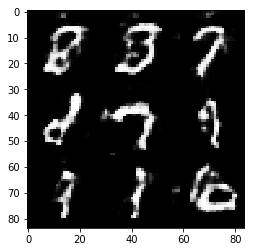

Epoch 9/20... Discriminator Loss: 1.9911... Generator Loss: 0.2954


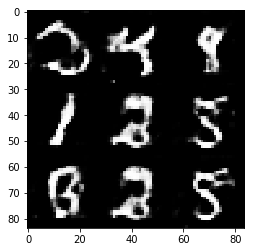

Epoch 10/20... Discriminator Loss: 0.0708... Generator Loss: 4.2111


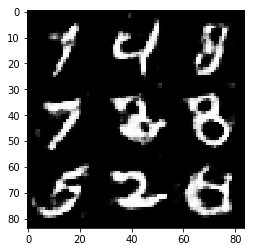

Epoch 10/20... Discriminator Loss: 0.4545... Generator Loss: 3.2342


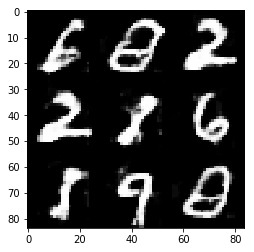

Epoch 10/20... Discriminator Loss: 0.4273... Generator Loss: 2.8799


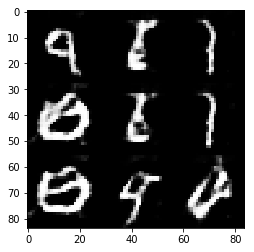

Epoch 10/20... Discriminator Loss: 0.4548... Generator Loss: 2.0772


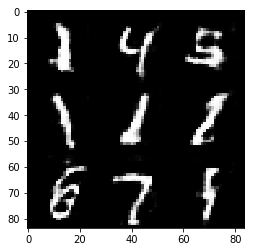

Epoch 10/20... Discriminator Loss: 0.5202... Generator Loss: 1.6723


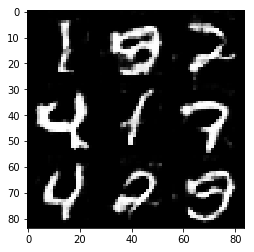

Epoch 11/20... Discriminator Loss: 0.1565... Generator Loss: 2.5704


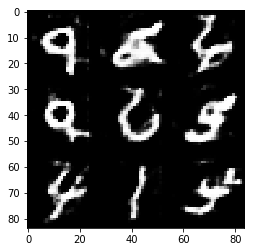

Epoch 11/20... Discriminator Loss: 0.2340... Generator Loss: 3.3325


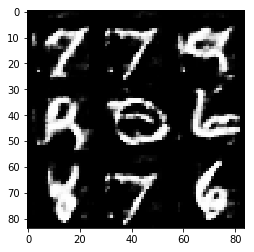

Epoch 11/20... Discriminator Loss: 0.5932... Generator Loss: 2.6584


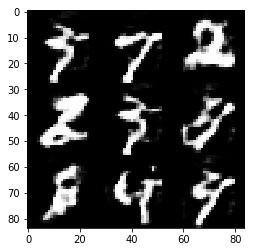

Epoch 11/20... Discriminator Loss: 0.6823... Generator Loss: 1.9224


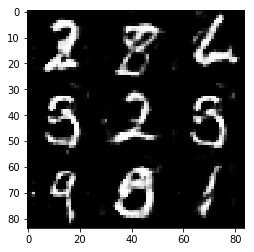

Epoch 11/20... Discriminator Loss: 0.3911... Generator Loss: 1.3057


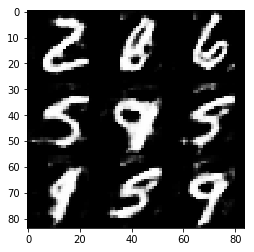

Epoch 12/20... Discriminator Loss: 0.0984... Generator Loss: 5.1321


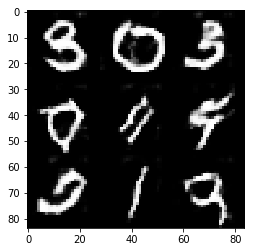

Epoch 12/20... Discriminator Loss: 0.1962... Generator Loss: 3.3351


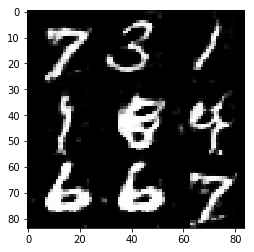

Epoch 12/20... Discriminator Loss: 0.4482... Generator Loss: 2.7666


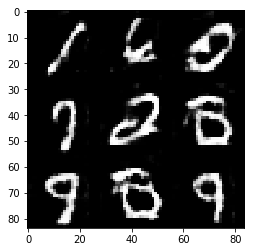

Epoch 12/20... Discriminator Loss: 0.1766... Generator Loss: 5.5932


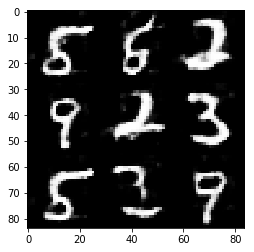

Epoch 12/20... Discriminator Loss: 0.2643... Generator Loss: 2.5440


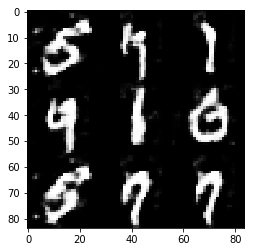

Epoch 13/20... Discriminator Loss: 0.2427... Generator Loss: 3.9975


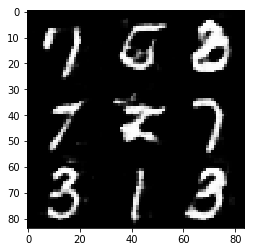

Epoch 13/20... Discriminator Loss: 1.4480... Generator Loss: 5.9718


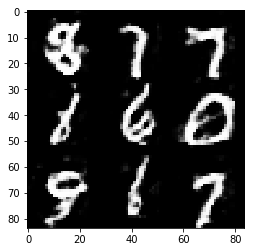

Epoch 13/20... Discriminator Loss: 0.0932... Generator Loss: 5.6032


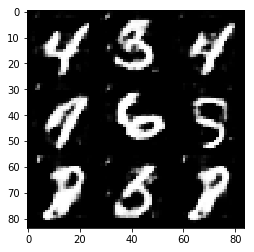

Epoch 13/20... Discriminator Loss: 0.6769... Generator Loss: 2.8671


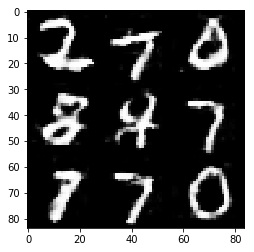

Epoch 13/20... Discriminator Loss: 0.4520... Generator Loss: 1.9627


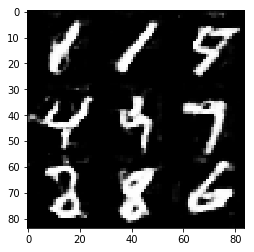

Epoch 14/20... Discriminator Loss: 0.2421... Generator Loss: 2.3364


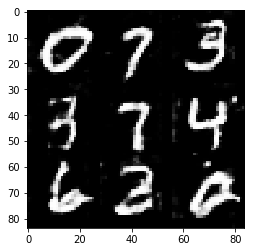

Epoch 14/20... Discriminator Loss: 0.0489... Generator Loss: 3.9944


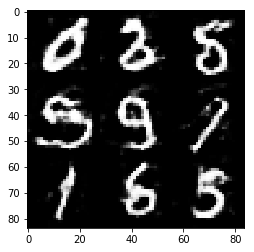

Epoch 14/20... Discriminator Loss: 0.1683... Generator Loss: 3.7516


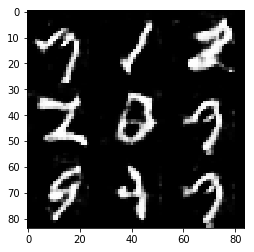

Epoch 14/20... Discriminator Loss: 0.1942... Generator Loss: 3.0770


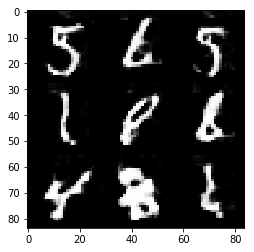

Epoch 14/20... Discriminator Loss: 0.1103... Generator Loss: 5.3371


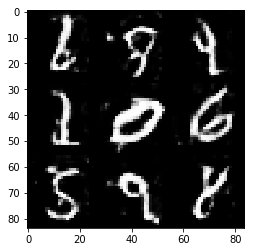

Epoch 15/20... Discriminator Loss: 0.1881... Generator Loss: 4.1562


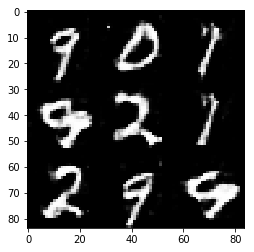

Epoch 15/20... Discriminator Loss: 1.3941... Generator Loss: 0.5257


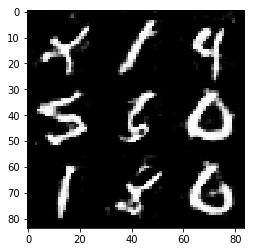

Epoch 15/20... Discriminator Loss: 0.0500... Generator Loss: 4.8702


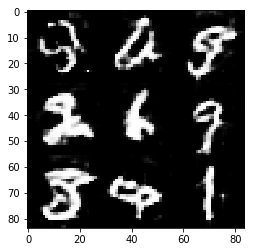

Epoch 15/20... Discriminator Loss: 0.1749... Generator Loss: 3.8317


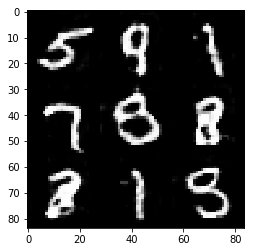

Epoch 15/20... Discriminator Loss: 0.5506... Generator Loss: 1.6184


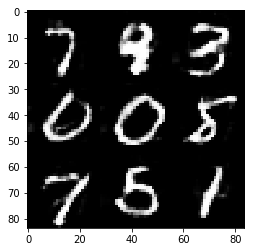

Epoch 16/20... Discriminator Loss: 0.1044... Generator Loss: 3.9752


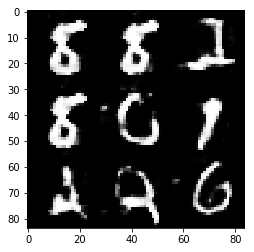

Epoch 16/20... Discriminator Loss: 0.1083... Generator Loss: 4.5529


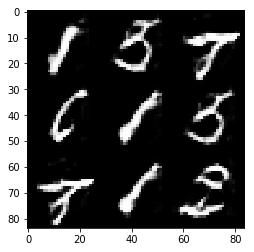

Epoch 16/20... Discriminator Loss: 0.0917... Generator Loss: 4.1321


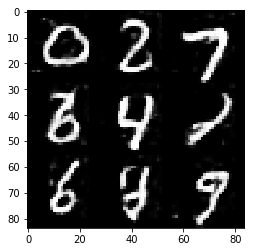

Epoch 16/20... Discriminator Loss: 0.4374... Generator Loss: 1.2518


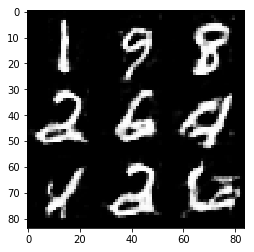

Epoch 16/20... Discriminator Loss: 0.0962... Generator Loss: 4.6135


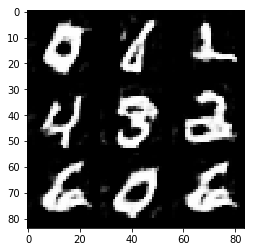

Epoch 17/20... Discriminator Loss: 0.1065... Generator Loss: 6.1743


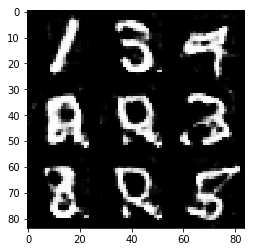

Epoch 17/20... Discriminator Loss: 0.5471... Generator Loss: 1.6764


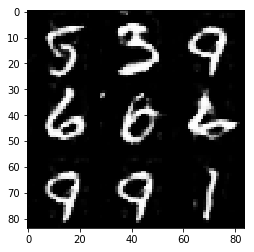

Epoch 17/20... Discriminator Loss: 0.2032... Generator Loss: 2.7493


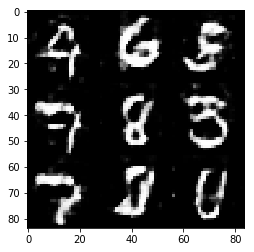

Epoch 17/20... Discriminator Loss: 0.6818... Generator Loss: 1.3730


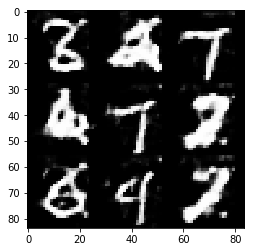

Epoch 17/20... Discriminator Loss: 0.2175... Generator Loss: 3.5959


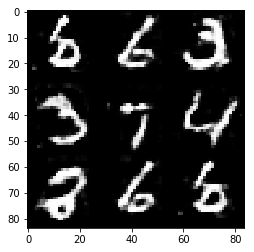

Epoch 18/20... Discriminator Loss: 0.1111... Generator Loss: 4.4006


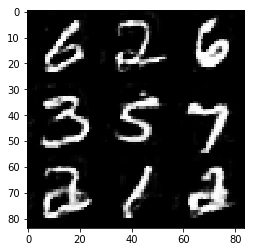

Epoch 18/20... Discriminator Loss: 0.1187... Generator Loss: 3.0372


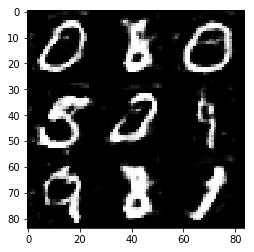

Epoch 18/20... Discriminator Loss: 0.1306... Generator Loss: 5.7461


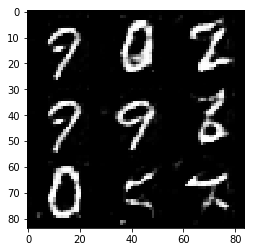

Epoch 18/20... Discriminator Loss: 0.0411... Generator Loss: 7.2613


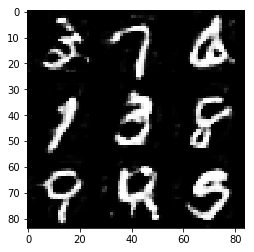

Epoch 18/20... Discriminator Loss: 1.3887... Generator Loss: 0.4248


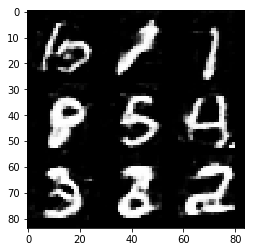

Epoch 19/20... Discriminator Loss: 0.0581... Generator Loss: 4.6777


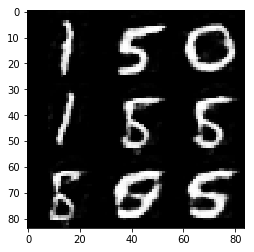

Epoch 19/20... Discriminator Loss: 0.4262... Generator Loss: 6.8978


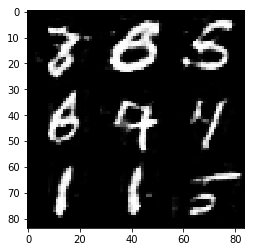

Epoch 19/20... Discriminator Loss: 0.0227... Generator Loss: 4.0270


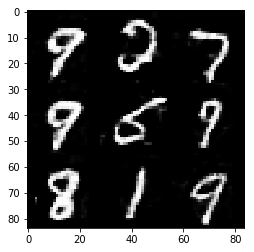

Epoch 19/20... Discriminator Loss: 0.0867... Generator Loss: 3.7846


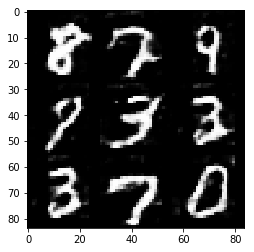

Epoch 19/20... Discriminator Loss: 0.3258... Generator Loss: 1.8004


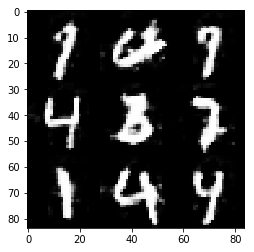

Epoch 20/20... Discriminator Loss: 0.1528... Generator Loss: 3.6450


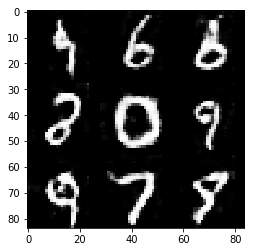

Epoch 20/20... Discriminator Loss: 0.0944... Generator Loss: 5.0982


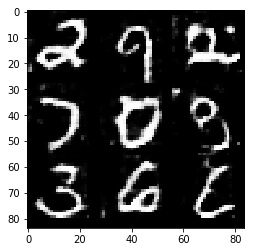

Epoch 20/20... Discriminator Loss: 0.2424... Generator Loss: 2.1624


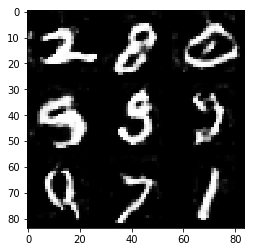

Epoch 20/20... Discriminator Loss: 0.7606... Generator Loss: 1.8045


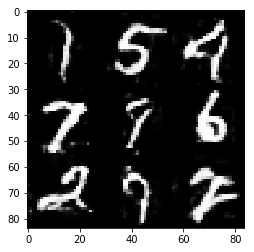

Epoch 20/20... Discriminator Loss: 0.3736... Generator Loss: 2.5015


IndexError: list index out of range

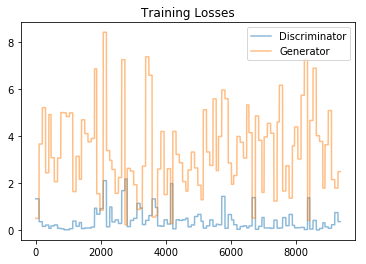

In [320]:
import matplotlib.pyplot as plt

batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 20

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

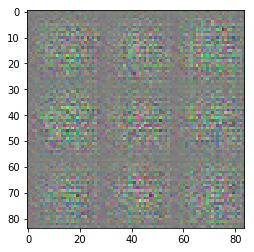

Epoch 1/20... Discriminator Loss: 0.1929... Generator Loss: 3.9523


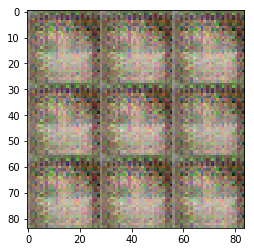

Epoch 1/20... Discriminator Loss: 0.1251... Generator Loss: 6.6369


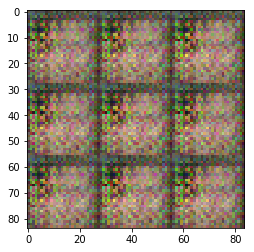

Epoch 1/20... Discriminator Loss: 0.0711... Generator Loss: 3.3133


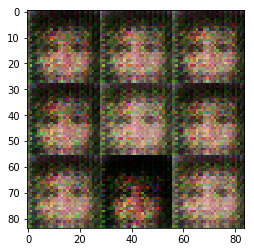

Epoch 1/20... Discriminator Loss: 0.8030... Generator Loss: 1.1340


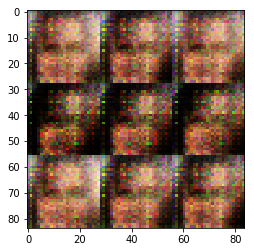

Epoch 1/20... Discriminator Loss: 0.8489... Generator Loss: 4.8027


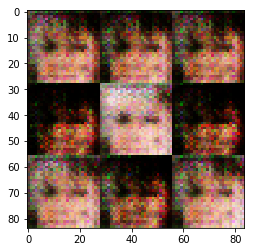

Epoch 1/20... Discriminator Loss: 0.1919... Generator Loss: 2.8987


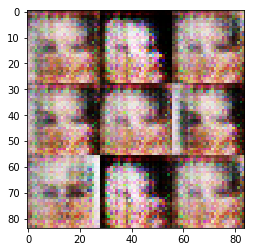

Epoch 1/20... Discriminator Loss: 0.2321... Generator Loss: 5.4881


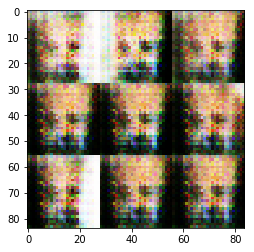

Epoch 1/20... Discriminator Loss: 0.2807... Generator Loss: 2.4050


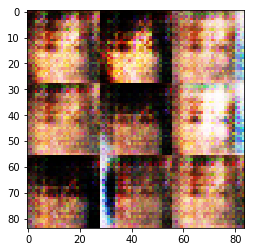

Epoch 1/20... Discriminator Loss: 0.4850... Generator Loss: 1.4793


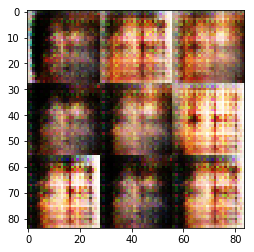

Epoch 1/20... Discriminator Loss: 0.7952... Generator Loss: 1.3341


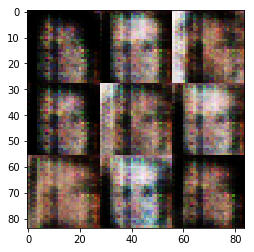

Epoch 1/20... Discriminator Loss: 0.2630... Generator Loss: 2.3100


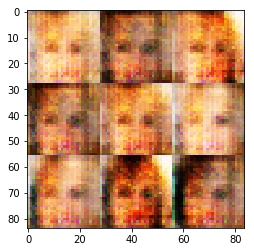

Epoch 1/20... Discriminator Loss: 0.2935... Generator Loss: 2.5897


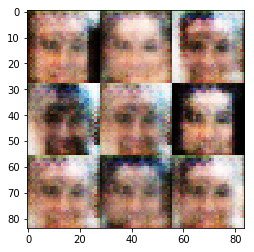

Epoch 1/20... Discriminator Loss: 0.7847... Generator Loss: 7.0178


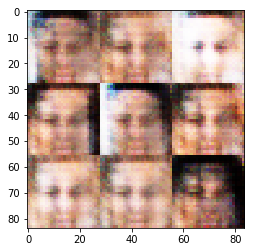

Epoch 1/20... Discriminator Loss: 0.3295... Generator Loss: 3.8253


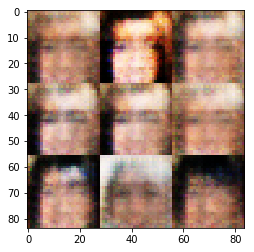

Epoch 1/20... Discriminator Loss: 0.1417... Generator Loss: 2.7219


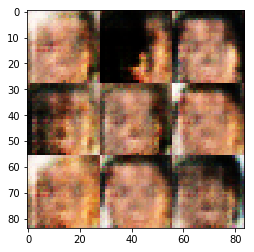

Epoch 1/20... Discriminator Loss: 0.5291... Generator Loss: 1.1266


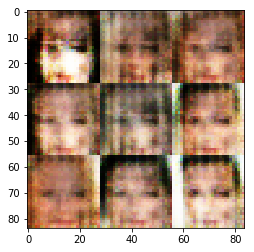

Epoch 2/20... Discriminator Loss: 0.7320... Generator Loss: 4.6640


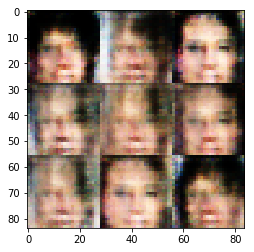

Epoch 2/20... Discriminator Loss: 0.4010... Generator Loss: 1.9846


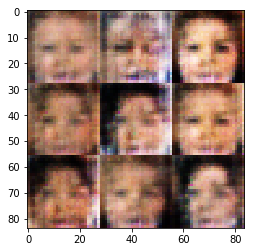

Epoch 2/20... Discriminator Loss: 0.4325... Generator Loss: 2.5198


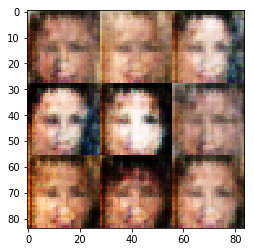

Epoch 2/20... Discriminator Loss: 0.8955... Generator Loss: 1.0031


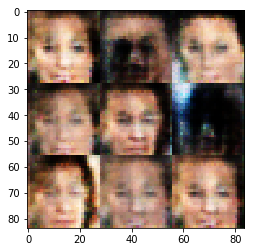

Epoch 2/20... Discriminator Loss: 0.2940... Generator Loss: 2.0092


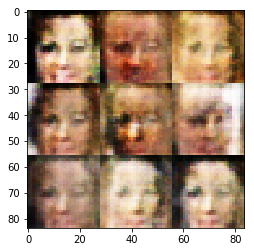

Epoch 2/20... Discriminator Loss: 1.6150... Generator Loss: 0.3606


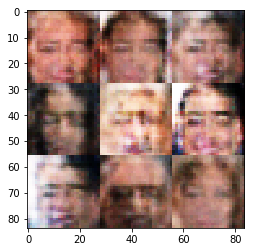

Epoch 2/20... Discriminator Loss: 0.2356... Generator Loss: 2.1980


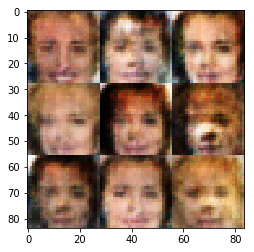

Epoch 2/20... Discriminator Loss: 0.5671... Generator Loss: 6.5069


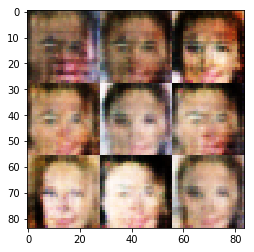

Epoch 2/20... Discriminator Loss: 0.6953... Generator Loss: 1.4269


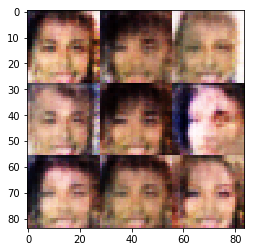

Epoch 2/20... Discriminator Loss: 0.3168... Generator Loss: 2.6339


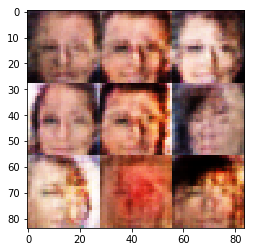

Epoch 2/20... Discriminator Loss: 1.2247... Generator Loss: 0.5567


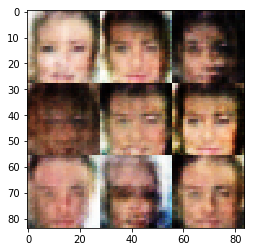

Epoch 2/20... Discriminator Loss: 0.4891... Generator Loss: 1.4271


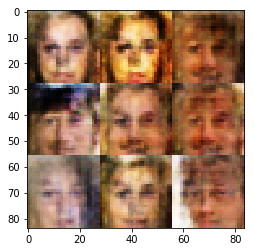

Epoch 2/20... Discriminator Loss: 0.4342... Generator Loss: 2.3675


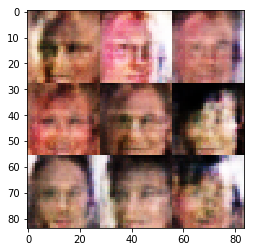

Epoch 2/20... Discriminator Loss: 0.3518... Generator Loss: 2.5040


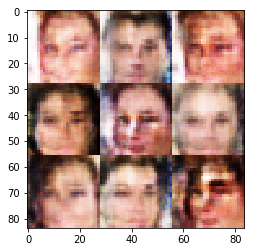

Epoch 2/20... Discriminator Loss: 0.2774... Generator Loss: 4.1054


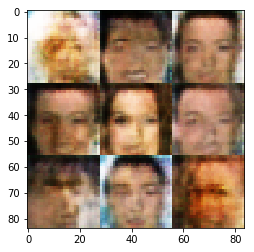

Epoch 2/20... Discriminator Loss: 0.3077... Generator Loss: 2.0379


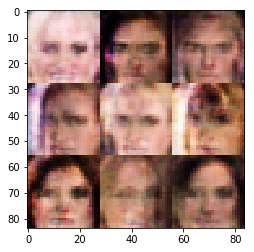

Epoch 3/20... Discriminator Loss: 0.2360... Generator Loss: 2.7001


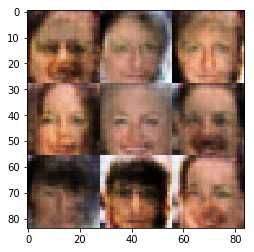

Epoch 3/20... Discriminator Loss: 1.7137... Generator Loss: 6.9396


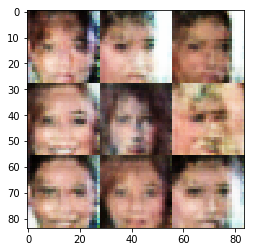

Epoch 3/20... Discriminator Loss: 0.5491... Generator Loss: 1.1966


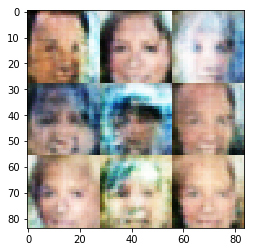

Epoch 3/20... Discriminator Loss: 0.8399... Generator Loss: 0.9725


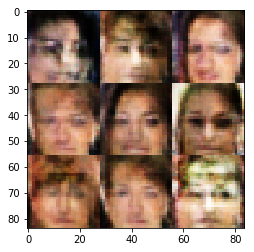

Epoch 3/20... Discriminator Loss: 1.7734... Generator Loss: 0.2355


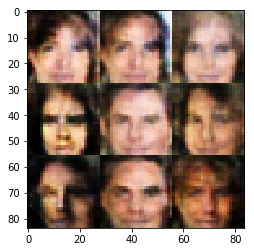

Epoch 3/20... Discriminator Loss: 1.0471... Generator Loss: 5.6267


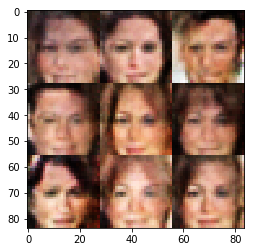

Epoch 3/20... Discriminator Loss: 0.4656... Generator Loss: 1.3378


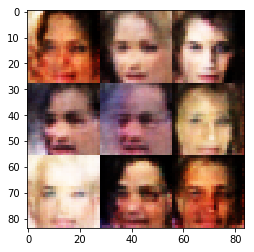

Epoch 3/20... Discriminator Loss: 0.2516... Generator Loss: 3.7134


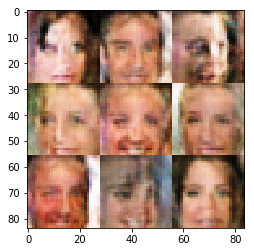

Epoch 3/20... Discriminator Loss: 0.4206... Generator Loss: 2.1743


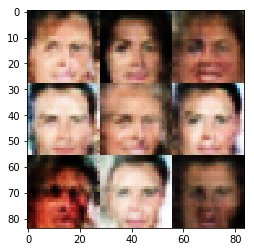

Epoch 3/20... Discriminator Loss: 0.2024... Generator Loss: 3.3140


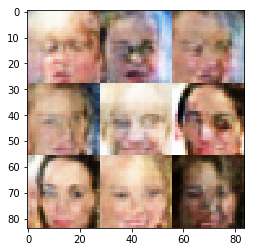

Epoch 3/20... Discriminator Loss: 0.0707... Generator Loss: 3.8731


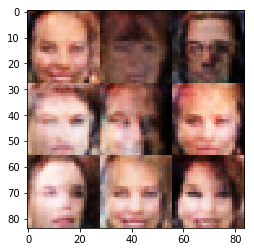

Epoch 3/20... Discriminator Loss: 0.4728... Generator Loss: 5.1282


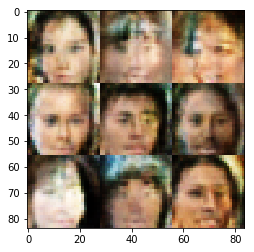

Epoch 3/20... Discriminator Loss: 0.6210... Generator Loss: 1.1109


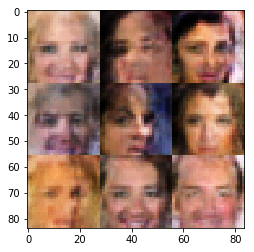

Epoch 3/20... Discriminator Loss: 0.6332... Generator Loss: 1.0718


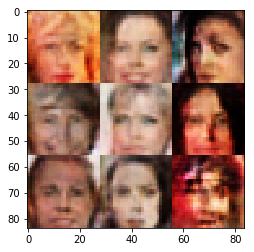

Epoch 3/20... Discriminator Loss: 0.3711... Generator Loss: 2.0869


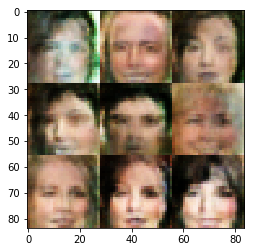

Epoch 3/20... Discriminator Loss: 0.1100... Generator Loss: 4.1374


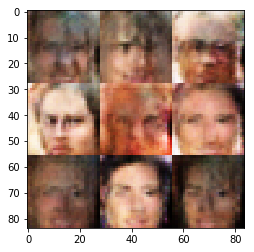

Epoch 4/20... Discriminator Loss: 0.4909... Generator Loss: 2.7374


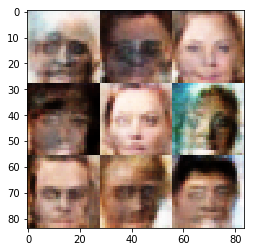

Epoch 4/20... Discriminator Loss: 1.4193... Generator Loss: 0.6198


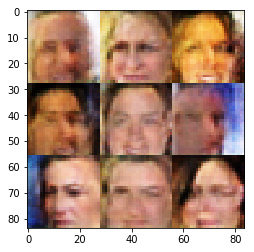

Epoch 4/20... Discriminator Loss: 1.1622... Generator Loss: 0.7992


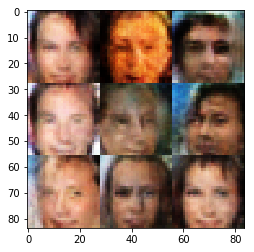

Epoch 4/20... Discriminator Loss: 0.4175... Generator Loss: 2.0334


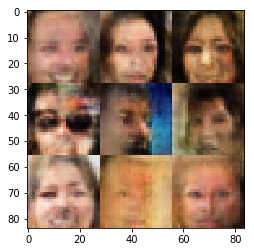

Epoch 4/20... Discriminator Loss: 0.4535... Generator Loss: 3.4597


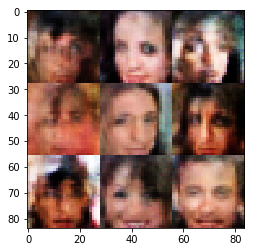

Epoch 4/20... Discriminator Loss: 0.7348... Generator Loss: 5.0656


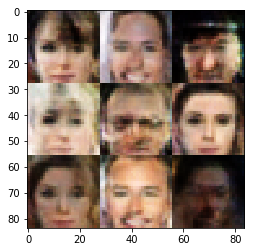

Epoch 4/20... Discriminator Loss: 0.7215... Generator Loss: 0.9717


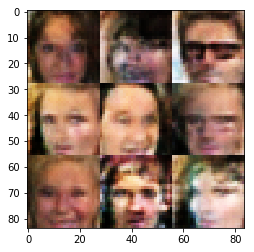

Epoch 4/20... Discriminator Loss: 0.2993... Generator Loss: 2.3265


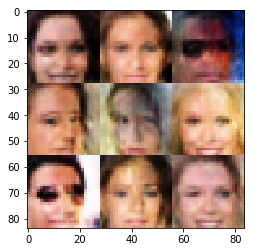

Epoch 4/20... Discriminator Loss: 0.5106... Generator Loss: 1.5110


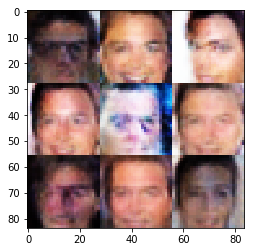

Epoch 4/20... Discriminator Loss: 0.4645... Generator Loss: 4.1085


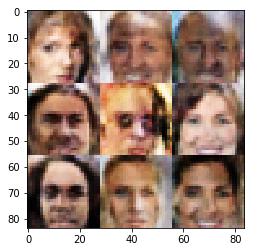

Epoch 4/20... Discriminator Loss: 1.0336... Generator Loss: 0.9235


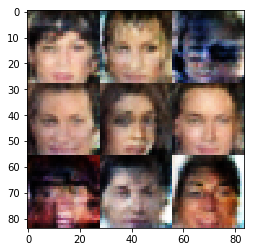

Epoch 4/20... Discriminator Loss: 0.6587... Generator Loss: 1.4509


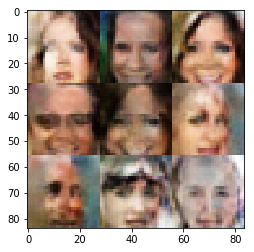

Epoch 4/20... Discriminator Loss: 0.2001... Generator Loss: 4.9499


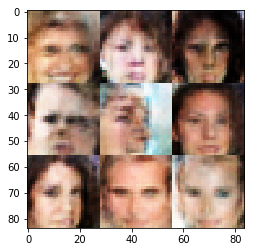

Epoch 4/20... Discriminator Loss: 0.2132... Generator Loss: 2.8595


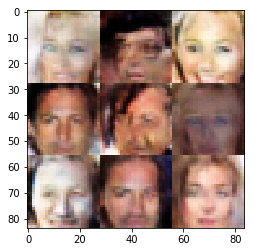

Epoch 4/20... Discriminator Loss: 0.9991... Generator Loss: 1.1884


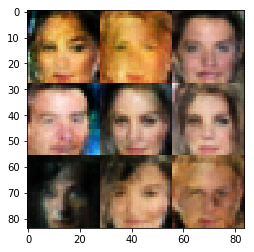

Epoch 4/20... Discriminator Loss: 0.9413... Generator Loss: 0.7634


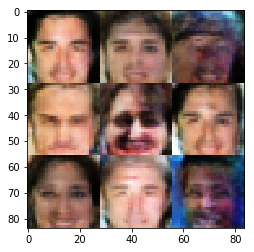

Epoch 5/20... Discriminator Loss: 0.4712... Generator Loss: 4.1330


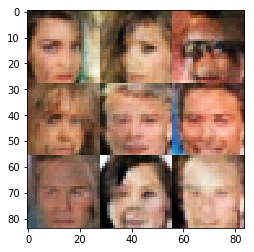

Epoch 5/20... Discriminator Loss: 0.4674... Generator Loss: 2.3073


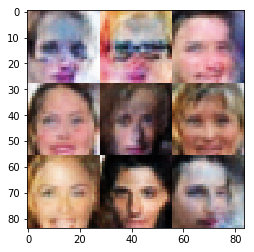

Epoch 5/20... Discriminator Loss: 1.5336... Generator Loss: 6.1424


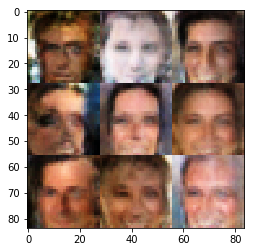

Epoch 5/20... Discriminator Loss: 1.0282... Generator Loss: 0.7333


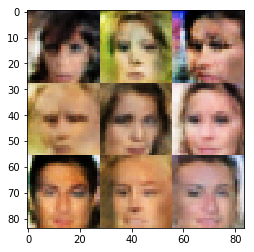

Epoch 5/20... Discriminator Loss: 0.6121... Generator Loss: 1.2745


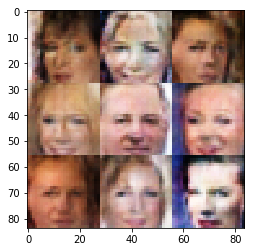

Epoch 5/20... Discriminator Loss: 0.8734... Generator Loss: 0.8123


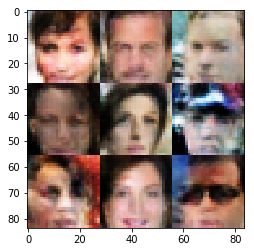

Epoch 5/20... Discriminator Loss: 0.7774... Generator Loss: 1.2544


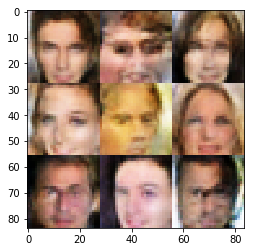

Epoch 5/20... Discriminator Loss: 0.8548... Generator Loss: 4.9569


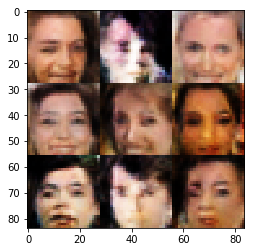

Epoch 5/20... Discriminator Loss: 0.4580... Generator Loss: 3.4871


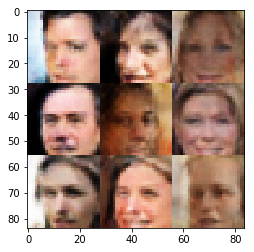

Epoch 5/20... Discriminator Loss: 0.4482... Generator Loss: 3.5794


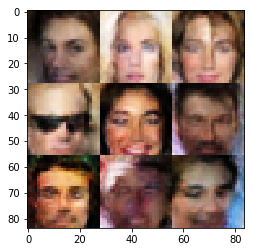

Epoch 5/20... Discriminator Loss: 2.0466... Generator Loss: 0.3392


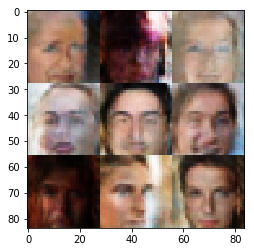

Epoch 5/20... Discriminator Loss: 0.6685... Generator Loss: 6.0012


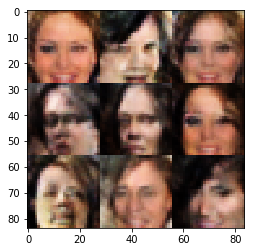

Epoch 5/20... Discriminator Loss: 0.4876... Generator Loss: 1.7591


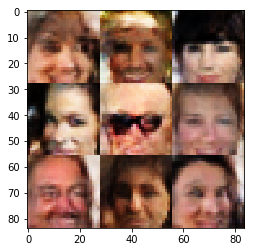

Epoch 5/20... Discriminator Loss: 0.2563... Generator Loss: 2.4436


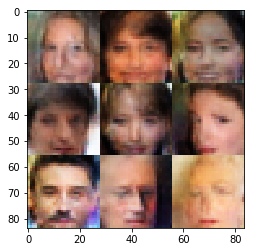

Epoch 5/20... Discriminator Loss: 0.8251... Generator Loss: 1.1457


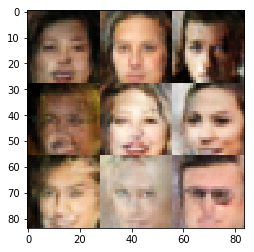

Epoch 5/20... Discriminator Loss: 0.2656... Generator Loss: 2.1778


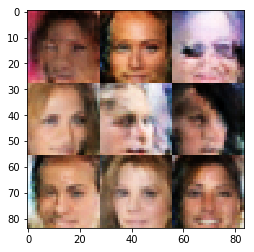

Epoch 6/20... Discriminator Loss: 0.2977... Generator Loss: 2.4627


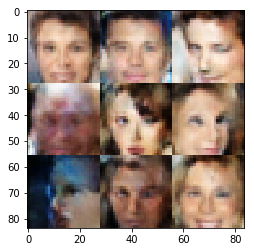

Epoch 6/20... Discriminator Loss: 0.2786... Generator Loss: 3.7070


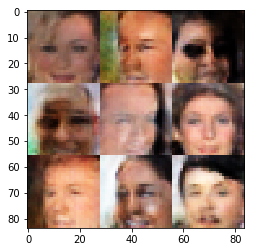

Epoch 6/20... Discriminator Loss: 2.7739... Generator Loss: 7.0111


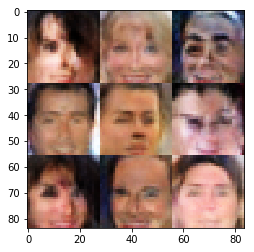

Epoch 6/20... Discriminator Loss: 0.4329... Generator Loss: 1.9263


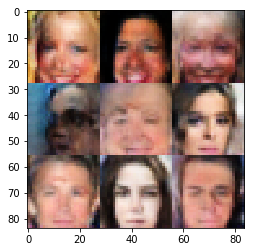

Epoch 6/20... Discriminator Loss: 0.6577... Generator Loss: 1.3374


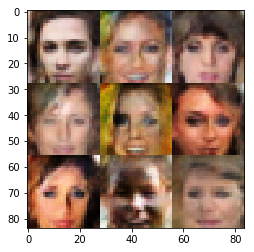

Epoch 6/20... Discriminator Loss: 1.2130... Generator Loss: 0.4724


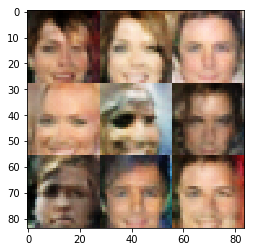

Epoch 6/20... Discriminator Loss: 0.2806... Generator Loss: 2.9437


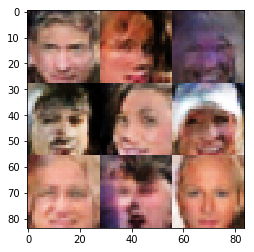

Epoch 6/20... Discriminator Loss: 0.5187... Generator Loss: 4.6025


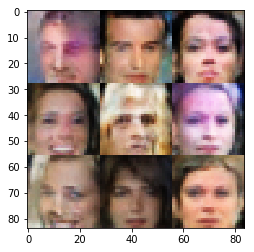

Epoch 6/20... Discriminator Loss: 0.3655... Generator Loss: 2.2253


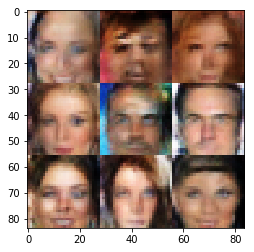

Epoch 6/20... Discriminator Loss: 0.9962... Generator Loss: 6.8521


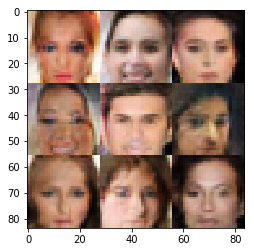

Epoch 6/20... Discriminator Loss: 0.2212... Generator Loss: 3.0161


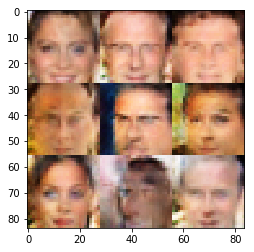

Epoch 6/20... Discriminator Loss: 0.3770... Generator Loss: 2.6765


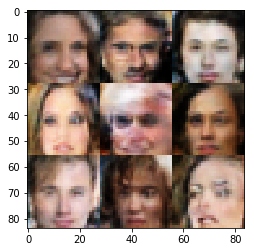

Epoch 6/20... Discriminator Loss: 0.3967... Generator Loss: 3.5092


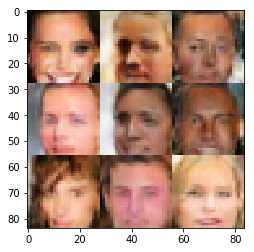

Epoch 6/20... Discriminator Loss: 0.2663... Generator Loss: 3.9919


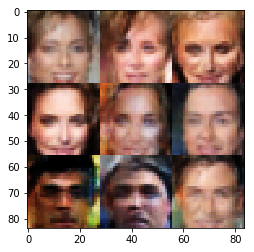

Epoch 6/20... Discriminator Loss: 0.2886... Generator Loss: 3.2257


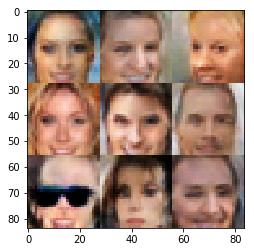

Epoch 6/20... Discriminator Loss: 0.5137... Generator Loss: 1.8313


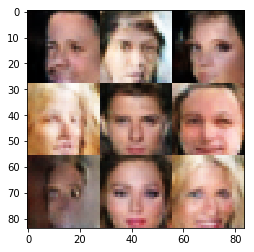

Epoch 7/20... Discriminator Loss: 0.2268... Generator Loss: 2.7144


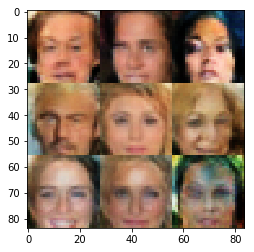

Epoch 7/20... Discriminator Loss: 0.4529... Generator Loss: 1.3464


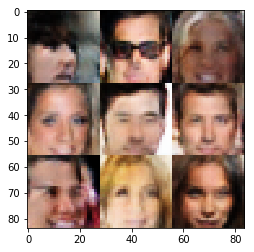

Epoch 7/20... Discriminator Loss: 0.5972... Generator Loss: 3.0446


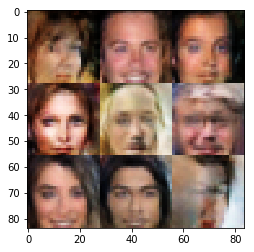

Epoch 7/20... Discriminator Loss: 0.4369... Generator Loss: 2.6204


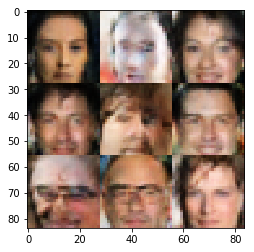

Epoch 7/20... Discriminator Loss: 0.7245... Generator Loss: 1.2288


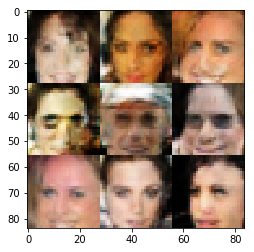

Epoch 7/20... Discriminator Loss: 0.4913... Generator Loss: 2.1190


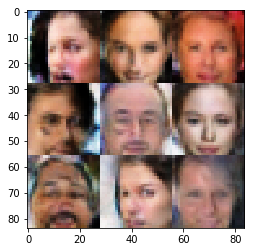

Epoch 7/20... Discriminator Loss: 0.7688... Generator Loss: 6.5296


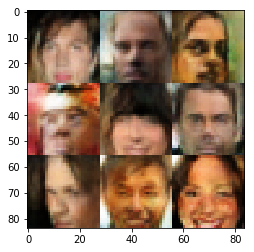

Epoch 7/20... Discriminator Loss: 0.4788... Generator Loss: 2.7546


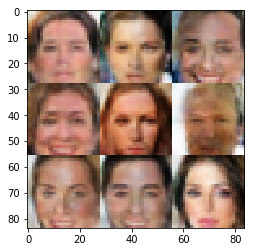

Epoch 7/20... Discriminator Loss: 0.7730... Generator Loss: 5.1460


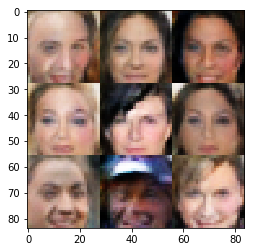

Epoch 7/20... Discriminator Loss: 0.3858... Generator Loss: 2.3533


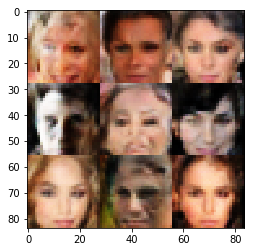

Epoch 7/20... Discriminator Loss: 1.4881... Generator Loss: 5.9975


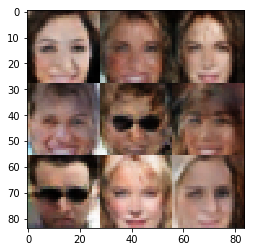

Epoch 7/20... Discriminator Loss: 0.4051... Generator Loss: 2.3598


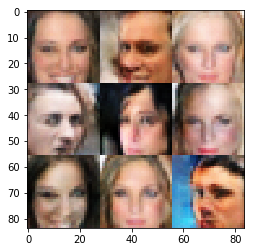

Epoch 7/20... Discriminator Loss: 0.6087... Generator Loss: 1.3613


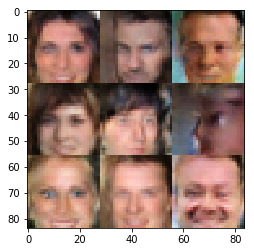

Epoch 7/20... Discriminator Loss: 0.4447... Generator Loss: 3.3420


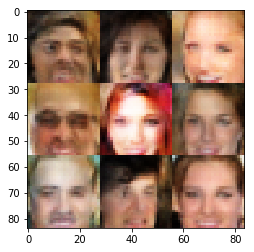

Epoch 7/20... Discriminator Loss: 0.4198... Generator Loss: 1.4955


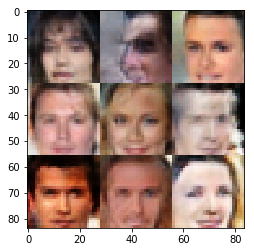

Epoch 7/20... Discriminator Loss: 1.0912... Generator Loss: 0.9190


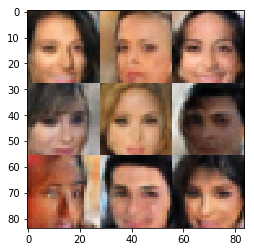

Epoch 8/20... Discriminator Loss: 0.4601... Generator Loss: 2.1161


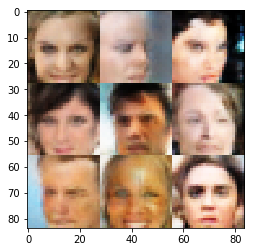

Epoch 8/20... Discriminator Loss: 0.2451... Generator Loss: 2.9268


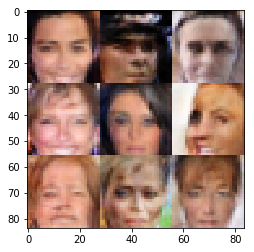

Epoch 8/20... Discriminator Loss: 0.7020... Generator Loss: 0.8838


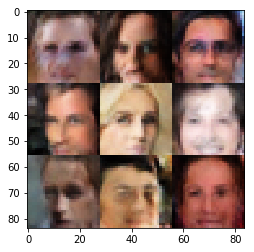

Epoch 8/20... Discriminator Loss: 0.2984... Generator Loss: 2.7256


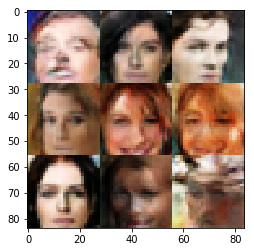

Epoch 8/20... Discriminator Loss: 1.0911... Generator Loss: 4.8339


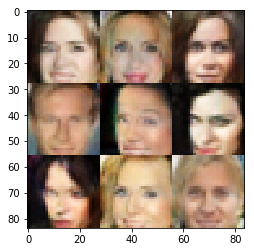

Epoch 8/20... Discriminator Loss: 0.5994... Generator Loss: 1.4036


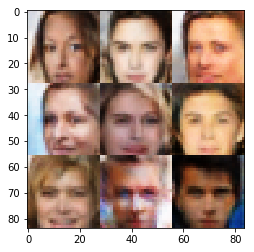

Epoch 8/20... Discriminator Loss: 1.7406... Generator Loss: 0.3655


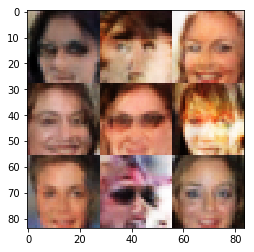

Epoch 8/20... Discriminator Loss: 1.2476... Generator Loss: 8.8886


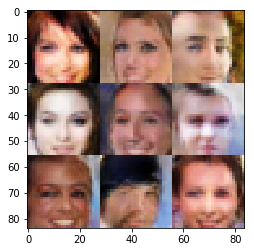

Epoch 8/20... Discriminator Loss: 0.1095... Generator Loss: 3.3284


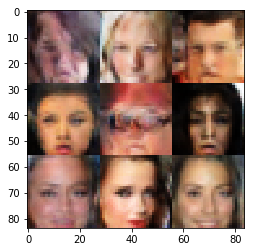

Epoch 8/20... Discriminator Loss: 0.4013... Generator Loss: 4.2156


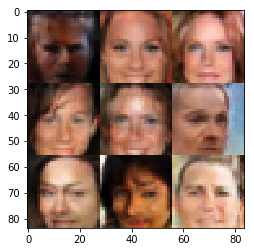

Epoch 8/20... Discriminator Loss: 0.5124... Generator Loss: 2.4951


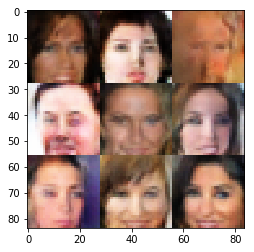

Epoch 8/20... Discriminator Loss: 0.1391... Generator Loss: 3.1378


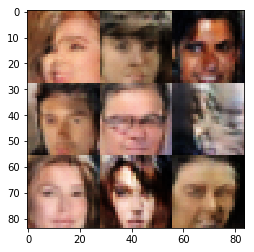

Epoch 8/20... Discriminator Loss: 0.2458... Generator Loss: 2.6017


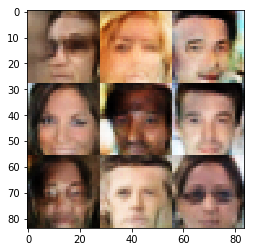

Epoch 8/20... Discriminator Loss: 0.3892... Generator Loss: 2.1424


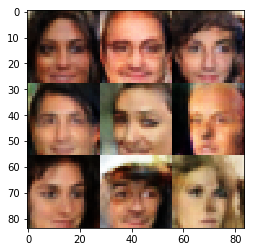

Epoch 8/20... Discriminator Loss: 0.4534... Generator Loss: 3.3015


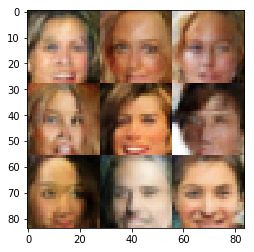

Epoch 8/20... Discriminator Loss: 0.1094... Generator Loss: 3.6866


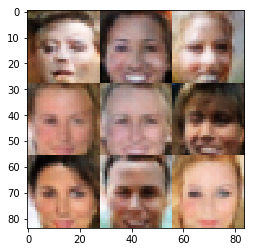

Epoch 9/20... Discriminator Loss: 0.1950... Generator Loss: 3.3534


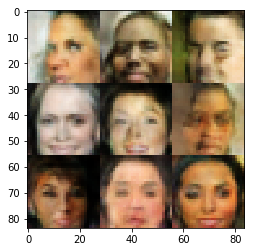

Epoch 9/20... Discriminator Loss: 0.8260... Generator Loss: 5.7195


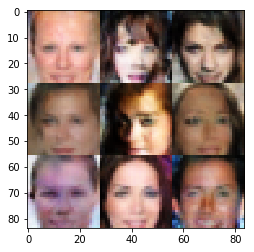

Epoch 9/20... Discriminator Loss: 0.6542... Generator Loss: 4.4779


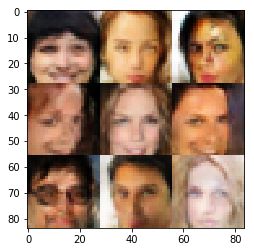

Epoch 9/20... Discriminator Loss: 0.3751... Generator Loss: 1.5714


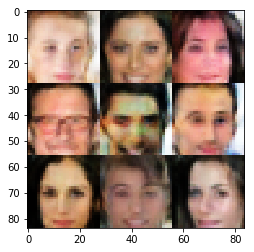

Epoch 9/20... Discriminator Loss: 0.6000... Generator Loss: 5.0754


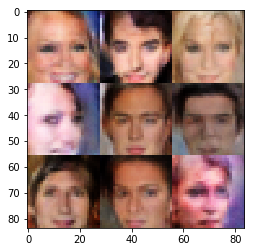

Epoch 9/20... Discriminator Loss: 0.2894... Generator Loss: 3.4882


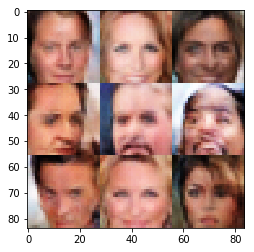

Epoch 9/20... Discriminator Loss: 0.6614... Generator Loss: 1.6335


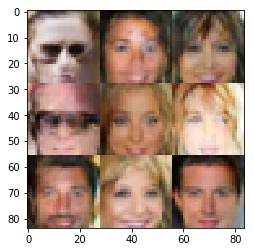

Epoch 9/20... Discriminator Loss: 0.9059... Generator Loss: 1.3516


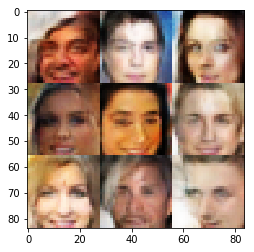

Epoch 9/20... Discriminator Loss: 0.3365... Generator Loss: 2.8297


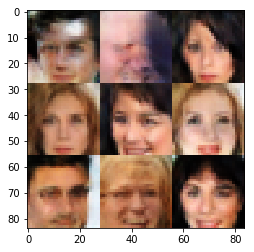

Epoch 9/20... Discriminator Loss: 0.2497... Generator Loss: 1.9067


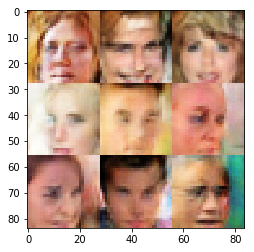

Epoch 9/20... Discriminator Loss: 0.7130... Generator Loss: 1.1135


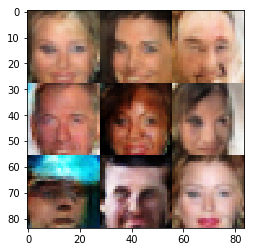

Epoch 9/20... Discriminator Loss: 0.2432... Generator Loss: 4.4969


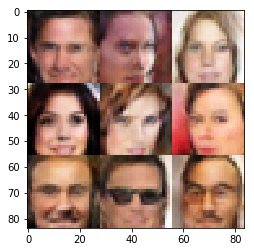

Epoch 9/20... Discriminator Loss: 0.2355... Generator Loss: 2.7354


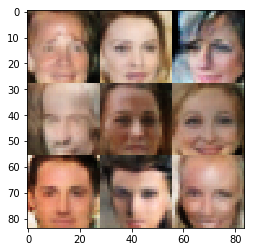

Epoch 9/20... Discriminator Loss: 0.4517... Generator Loss: 1.3899


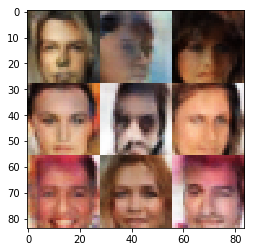

Epoch 9/20... Discriminator Loss: 0.8082... Generator Loss: 6.7675


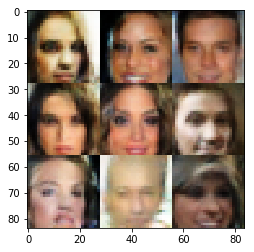

Epoch 9/20... Discriminator Loss: 0.3959... Generator Loss: 2.0743


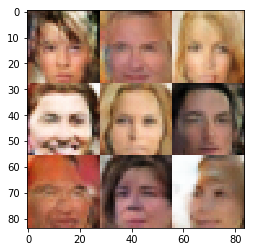

Epoch 10/20... Discriminator Loss: 0.3576... Generator Loss: 2.0893


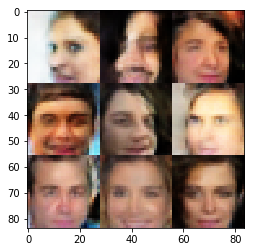

Epoch 10/20... Discriminator Loss: 0.6067... Generator Loss: 1.0806


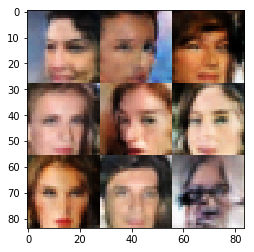

Epoch 10/20... Discriminator Loss: 0.8996... Generator Loss: 0.7762


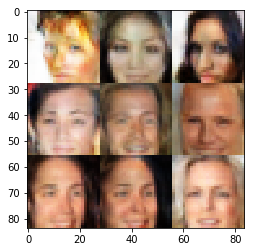

Epoch 10/20... Discriminator Loss: 0.5693... Generator Loss: 0.8998


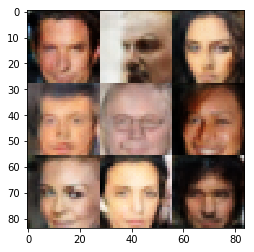

Epoch 10/20... Discriminator Loss: 0.4748... Generator Loss: 5.4608


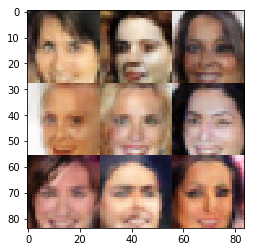

Epoch 10/20... Discriminator Loss: 0.3806... Generator Loss: 1.7329


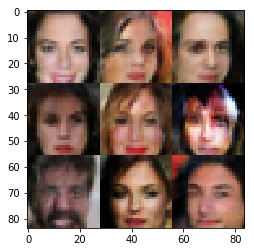

Epoch 10/20... Discriminator Loss: 0.3855... Generator Loss: 2.6131


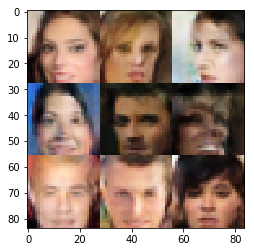

Epoch 10/20... Discriminator Loss: 0.5927... Generator Loss: 7.1178


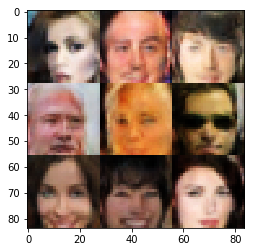

Epoch 10/20... Discriminator Loss: 0.4428... Generator Loss: 2.4814


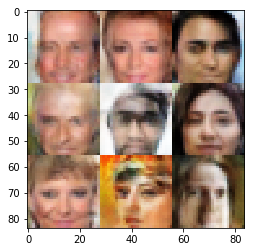

Epoch 10/20... Discriminator Loss: 0.1727... Generator Loss: 3.4928


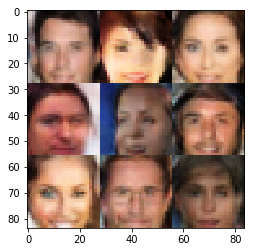

Epoch 10/20... Discriminator Loss: 1.3579... Generator Loss: 0.4872


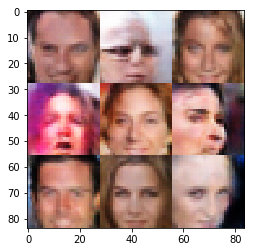

Epoch 10/20... Discriminator Loss: 0.2891... Generator Loss: 2.0889


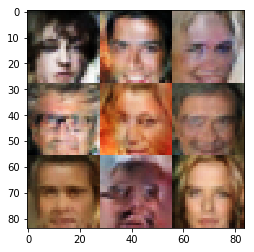

Epoch 10/20... Discriminator Loss: 0.3564... Generator Loss: 3.7577


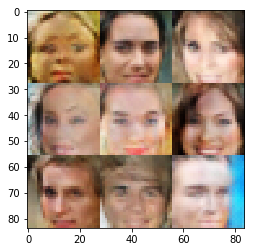

Epoch 10/20... Discriminator Loss: 0.2059... Generator Loss: 2.1161


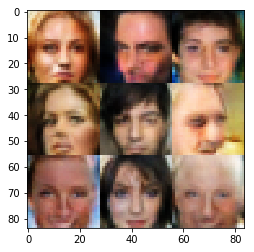

Epoch 10/20... Discriminator Loss: 0.3231... Generator Loss: 2.4608


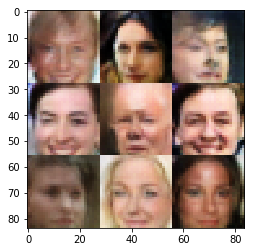

Epoch 10/20... Discriminator Loss: 0.1286... Generator Loss: 4.2219


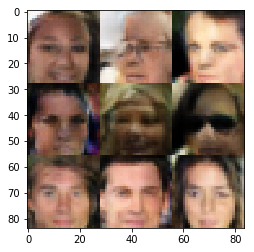

Epoch 11/20... Discriminator Loss: 0.1488... Generator Loss: 3.7150


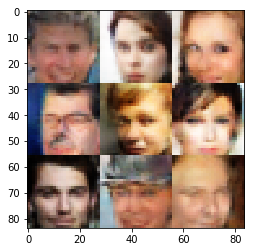

Epoch 11/20... Discriminator Loss: 0.5170... Generator Loss: 1.6047


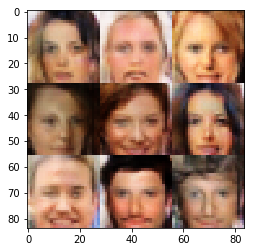

Epoch 11/20... Discriminator Loss: 1.9919... Generator Loss: 0.4143


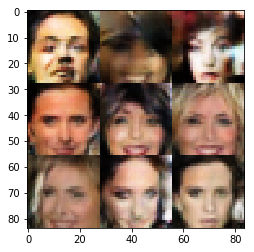

Epoch 11/20... Discriminator Loss: 1.9014... Generator Loss: 0.4510


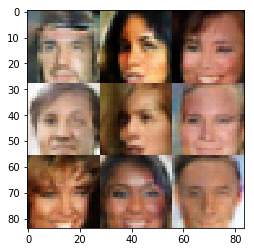

Epoch 11/20... Discriminator Loss: 0.4455... Generator Loss: 1.7058


IndexError: list index out of range

In [334]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 20

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.